**Classification analysis of a Thyroid Disease Data Set**



---




# Data

**Main link:** 

http://archive.ics.uci.edu/ml/datasets/thyroid+disease


**Data Set Information:**

          General Description of Thyroid Disease Databases 
                        and Related Files

This directory contains 6 databases, corresponding test set, and 
corresponding documentation.  They were left at the University of
California at Irvine by Ross Quinlan during his visit in 1987 for
the 1987 Machine Learning Workshop.  

The documentation files (with file extension "names") are formatted to
be read by Quinlan's C4 decision tree program.  Though briefer than
the other documentation files found in this database repository, they
should suffice to describe the database, specifically:

    1. Source
    2. Number and names of attributes (including class names)
    3. Types of values that each attribute takes

In general, these databases are quite similar and can be characterized
somewhat as follows:

    1. Many attributes (29 or so, mostly the same set over all the databases) mostly numeric or Boolean valued attributes
    3. thyroid disease domains (records provided by the Garavan Institute
       of Sydney, Australia)
    4. several missing attribute values (signified by "?")
    5. small number of classes (under 10, changes with each database)
    7. 2800 instances in each data set
    8. 972 instances in each test set (It seems that the test sets' instances
       are disjoint with respect to the corresponding data sets, but this has 
       not been verified)

As we can see below, some changes were maid in the original dataset - test and train data was joined together. 

**Independent Variables:**

There is no information provided about individual variables

**Target variable:**

* `Class`

# EDA

## Imports

In [1]:
%matplotlib inline

!pip3 install pandas_profiling --upgrade
import pandas as pd
import ydata_profiling

import numpy as np
#import os
#import random
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from statsmodels.graphics.mosaicplot import mosaic

import missingno as msno
#from pathlib import Path

plt.rcParams['figure.figsize'] = 10, 7
plt.style.use('ggplot')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 KB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.9/344.9 KB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 KB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 20.5 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.65.0
    Uninstalling tqdm-4.65.0:
      Successfully uninstalled tqdm-4.65.0
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1

### sklearn

In [2]:
from sklearn.model_selection import GridSearchCV, cross_validate, \
  KFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer, accuracy_score, precision_score, \
  recall_score, f1_score, precision_recall_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [3]:
!pip install catboost
from catboost import CatBoostClassifier

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 11.5 MB/s eta 0:00:00


### TF

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

## Data read

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/Myoth13/datasets/main/dataset_57_hypothyroid.csv', 
                 na_values=['?'], true_values=['t'], false_values=['f'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        3771 non-null   float64
 1   sex                        3622 non-null   object 
 2   on_thyroxine               3772 non-null   bool   
 3   query_on_thyroxine         3772 non-null   bool   
 4   on_antithyroid_medication  3772 non-null   bool   
 5   sick                       3772 non-null   bool   
 6   pregnant                   3772 non-null   bool   
 7   thyroid_surgery            3772 non-null   bool   
 8   I131_treatment             3772 non-null   bool   
 9   query_hypothyroid          3772 non-null   bool   
 10  query_hyperthyroid         3772 non-null   bool   
 11  lithium                    3772 non-null   bool   
 12  goitre                     3772 non-null   bool   
 13  tumor                      3772 non-null   bool 

We can see:


1.   There are one totally empty column: `TBG` and some missing data in others
2. columns `TSH_measured`, `T3_measured`,`TT4_measured`, `T4U_measured`, `FTI_measured`, `TBG_measured` can be drop because they are just indicators for a corresponding float value. 


Let's begin by dropping an empty column

In [6]:
df.drop(['TBG', 'TSH_measured', 'T3_measured', 'TT4_measured', 'T4U_measured',
         'FTI_measured', 'TBG_measured'], axis=1, inplace=True)

## Data type constrains

Let's see what's inside of the dataset

In [7]:
pd.set_option('display.max_columns', None)
display(df.loc[100:110,:])

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,referral_source,Class
100,28.0,F,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1.30,1.4,120.0,0.82,146.0,SVI,negative
101,62.0,M,False,False,False,True,False,False,False,False,False,False,False,False,False,False,12.00,1.5,105.0,0.86,122.0,other,compensated_hypothyroid
102,31.0,M,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1.40,2.3,150.0,1.42,106.0,SVHC,negative
103,71.0,F,True,False,False,False,False,False,False,False,True,False,False,False,False,False,0.50,NaN,126.0,1.02,124.0,other,negative
104,57.0,F,False,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,other,negative
105,78.0,M,False,False,False,True,False,False,False,False,False,False,False,False,False,False,2.10,1.8,80.0,0.72,111.0,other,negative
106,58.0,NaN,True,False,False,False,False,False,False,False,True,False,False,False,False,False,0.01,3.3,129.0,1.23,105.0,SVI,negative
107,18.0,M,False,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN,2.4,86.0,1.01,85.0,other,negative
108,59.0,F,False,False,False,False,False,False,False,False,False,False,False,False,False,False,4.10,3.1,110.0,1.06,104.0,SVI,negative
109,77.0,M,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.60,1.2,146.0,0.93,157.0,SVI,negative


In [8]:
df[['sex', 'referral_source', 'Class']] = df[['sex', 'referral_source', 'Class']].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   age                        3771 non-null   float64 
 1   sex                        3622 non-null   category
 2   on_thyroxine               3772 non-null   bool    
 3   query_on_thyroxine         3772 non-null   bool    
 4   on_antithyroid_medication  3772 non-null   bool    
 5   sick                       3772 non-null   bool    
 6   pregnant                   3772 non-null   bool    
 7   thyroid_surgery            3772 non-null   bool    
 8   I131_treatment             3772 non-null   bool    
 9   query_hypothyroid          3772 non-null   bool    
 10  query_hyperthyroid         3772 non-null   bool    
 11  lithium                    3772 non-null   bool    
 12  goitre                     3772 non-null   bool    
 13  tumor                      3772 n

Now our datatypes looks alright. !Caution: I will not use scikit-learn's encoders on the target var, because it works just fine with native pandas category type. 

## Uniqness constrains

Let's check for duplicate rows:

In [9]:
df.duplicated().sum()

61

Let's drop them

In [10]:
df.drop_duplicates(inplace=True)

## Missing data

Let's see overall amount of missing values

<Axes: >

Text(0.5, 1.0, 'Percent of non-null values by variable')

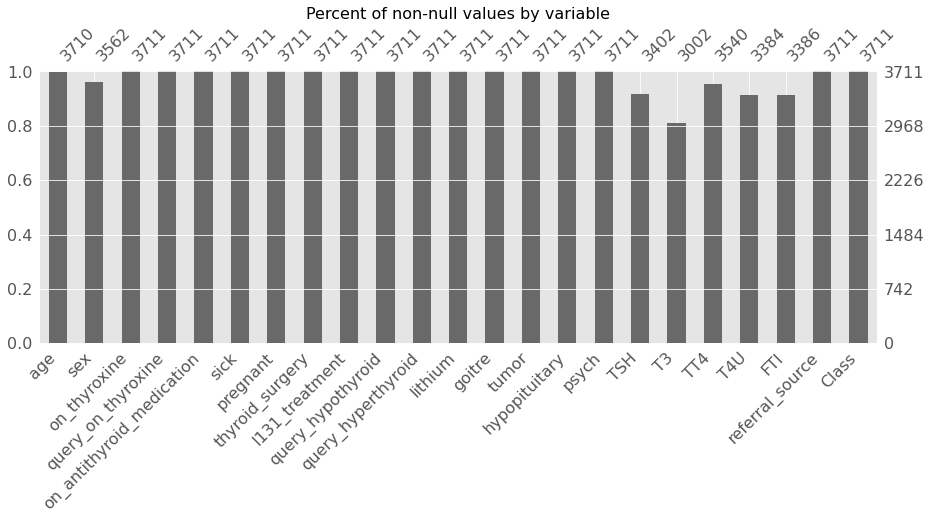

In [11]:
msno.bar(df, figsize=(15, 5))
plt.title('Percent of non-null values by variable', fontsize=16)
plt.show()

We can see, that all columns has decent % of data available and it's fine to impute it.

Now let's see the pattern of missingness:

<Axes: >

Text(0.5, 1.0, 'Missing values by variable')

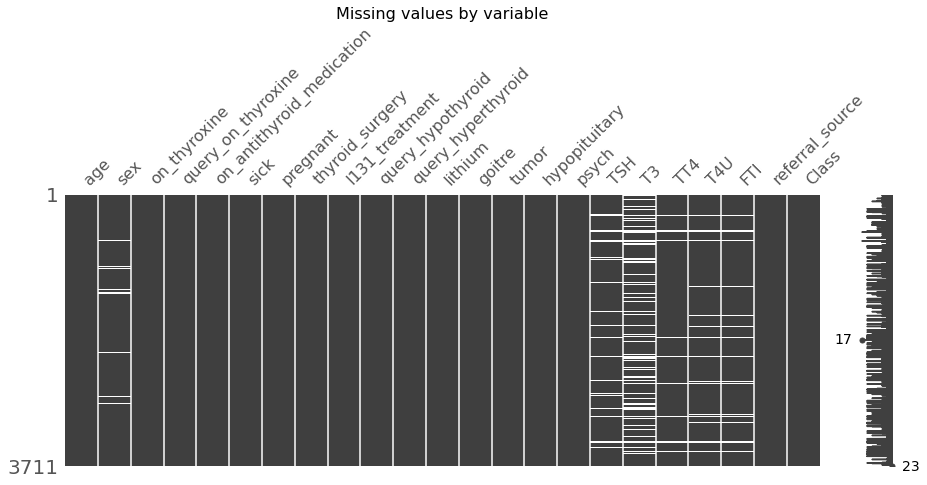

In [12]:
df.sort_values('Class', inplace=True)
msno.matrix(df, figsize=(15, 5))
plt.title('Missing values by variable', fontsize=16)
plt.show()

We can see a very interesting pattern here:
* Missing data in the variables looks almost random (almost the same pattern can be seen across `TT4`, `T4U`, and `FTI`). I will impute it later in the pipeline.

## Useless data and constans

Let's check for useless fields:

In [13]:
(df.nunique()/len(df)).sort_values(ascending=False)

TSH                          0.077338
TT4                          0.064942
FTI                          0.063056
T4U                          0.039342
age                          0.025061
T3                           0.018593
referral_source              0.001347
Class                        0.001078
I131_treatment               0.000539
query_hypothyroid            0.000539
query_hyperthyroid           0.000539
sex                          0.000539
goitre                       0.000539
tumor                        0.000539
hypopituitary                0.000539
psych                        0.000539
thyroid_surgery              0.000539
pregnant                     0.000539
sick                         0.000539
on_antithyroid_medication    0.000539
query_on_thyroxine           0.000539
on_thyroxine                 0.000539
lithium                      0.000539
dtype: float64

There are no columns with all unique values. 

Let's check for constants - fields with zero variance among numerical columns:

In [14]:
df.var().sort_values(ascending=True)

hypopituitary                   0.000269
lithium                         0.004828
goitre                          0.009080
on_antithyroid_medication       0.011193
query_on_thyroxine              0.013296
pregnant                        0.014082
thyroid_surgery                 0.014082
I131_treatment                  0.015650
tumor                           0.025207
sick                            0.038053
T4U                             0.038214
psych                           0.047137
query_hypothyroid               0.059096
query_hyperthyroid              0.059096
on_thyroxine                    0.109430
T3                              0.684875
age                           404.958661
TSH                           601.475529
FTI                          1094.836671
TT4                          1267.725411
dtype: float64

We can see here that we don't have zero variance fields which means we don't have constans. 

## Data range constrains

Let's see the overall statistics over numerical variables:

In [15]:
df.describe()

,age,TSH,T3,TT4,T4U,FTI
count,3710.000000,3402.000000,3002.000000,3540.000000,3384.000000,3386.000000
mean,51.860377,5.087820,2.013504,108.328475,0.994989,110.480715
std,20.123585,24.524998,0.827572,35.605132,0.195485,33.088316
min,1.000000,0.005000,0.050000,2.000000,0.250000,2.000000
25%,36.000000,0.500000,1.600000,88.000000,0.880000,93.000000
50%,54.000000,1.400000,2.000000,103.000000,0.980000,107.000000
75%,67.000000,2.700000,2.400000,124.000000,1.080000,124.000000
max,455.000000,530.000000,10.600000,430.000000,2.320000,395.000000


We can see here that: 
* `age` for sure has some mistakes bc max value of 455 is unrealistic 
* `TSH` of 530 is also too high value
Let's see levels of categorical variables 

In [16]:
df.drop(df[df.age > 100].index, inplace = True)

## Target variable

Let's look at the distribution of the target variable:

In [17]:
df['Class'].value_counts()
fig = px.histogram(
    data_frame=df,
    x='Class',
    title='Distribution of the target variable',
#    nbins=20,
    width = 600,
    height = 500
    )
fig.show()

negative                   3419
compensated_hypothyroid     194
primary_hypothyroid          95
secondary_hypothyroid         2
Name: Class, dtype: int64

We can see that our target variable is highly imbalanced, whith only two observations of `secondary_hypothyroid` level. No oversampling technique can help with such a small number of observations, so I will combine secondary and primary into one level and try multicalss with only three classes. 

In [18]:
df['Class'].replace(['secondary_hypothyroid','primary_hypothyroid'], 'sec_or_pr_hypothyroid', inplace=True)

## Independent variables

### Distribution of numerical vars

In [19]:
num_cols = df.select_dtypes('number').columns.to_list()

Text(0.5, 0.98, 'Distribution of the numeric variables')

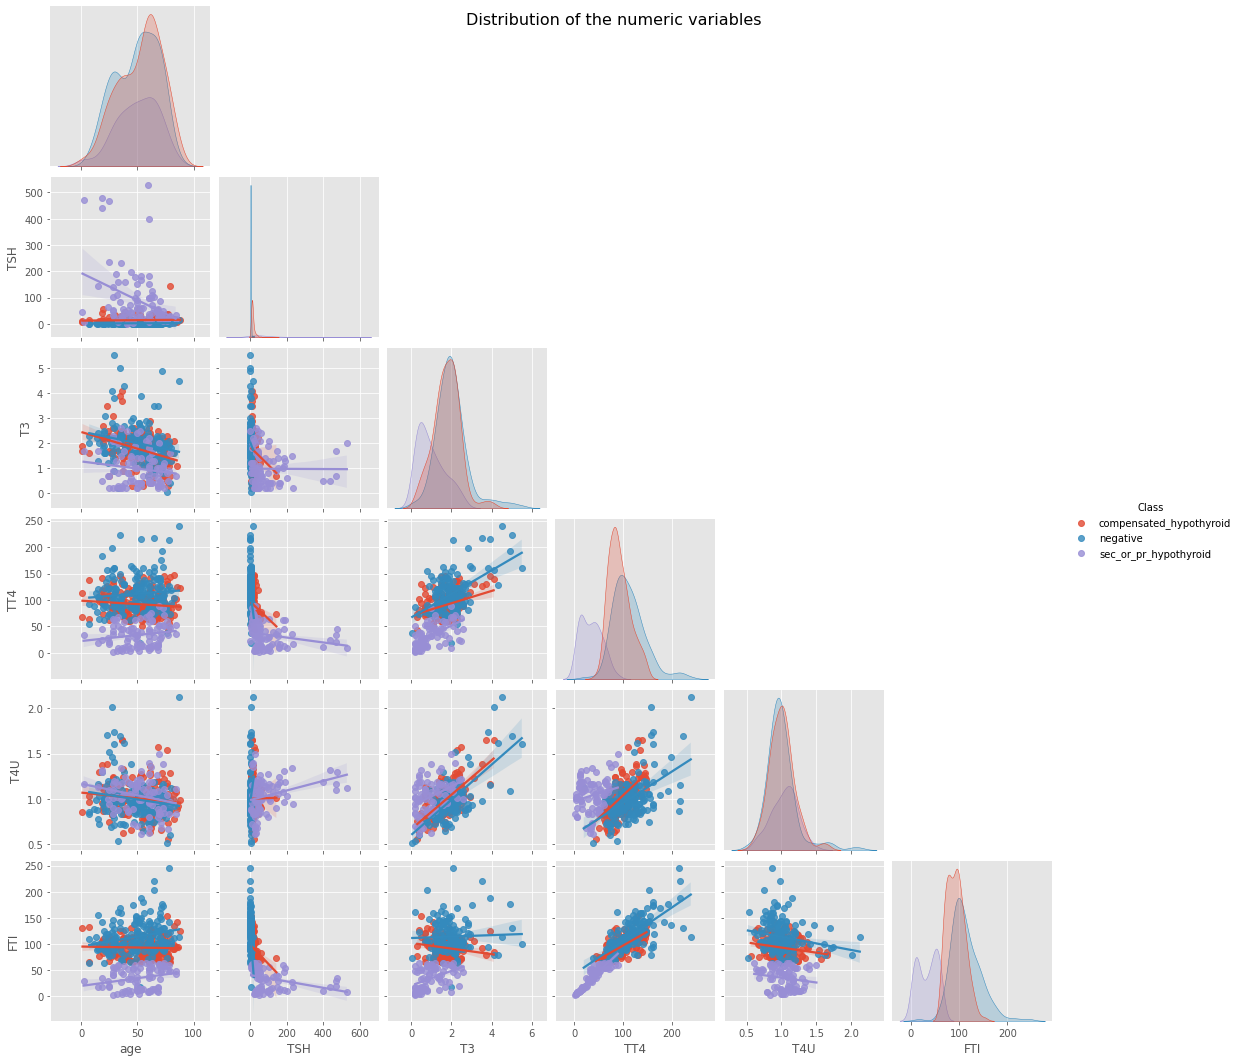

In [20]:
plot_cols = num_cols + ['Class']
df_neg_small = df[df.Class=='negative'].sample(df[df.Class=='compensated_hypothyroid'].shape[0])
df_small = pd.concat([
    df_neg_small,
    df[df.Class=='compensated_hypothyroid'],
    df[df.Class=='sec_or_pr_hypothyroid']])
sns.pairplot(df_small[plot_cols], corner=True, kind="reg", hue='Class')
plt.suptitle('Distribution of the numeric variables', fontsize=16)
plt.show()

We can see here that `TSH`, `TT4` and `FTI` have quite a difference in the distributions

### Correlations

Let's look at the correlations between variables. I will use original dataset, o I will use spearmans correlation coefficient instead of Pearsons because of the non-linearity

<Axes: >

Text(0.5, 1.0, 'Spearmans corr')

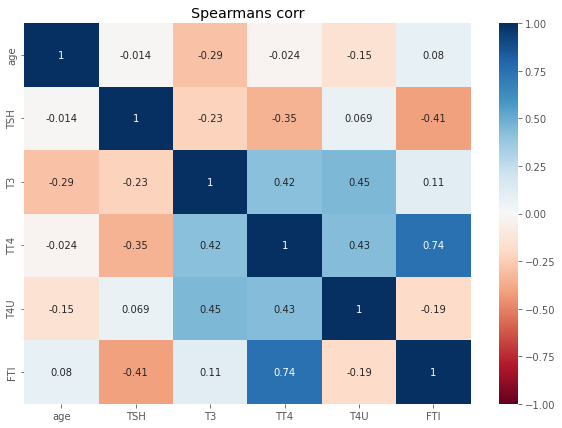

In [21]:
corr_table = df[plot_cols].corr(method='spearman')
sns.heatmap(corr_table, cmap='RdBu', annot=True, vmin=-1, vmax=1)
plt.title('Spearmans corr')
plt.show()

We can see here:

* Among numeric variables there aren't very strong correlations (close to 1). Let's see the distribution of numerical vars by target  

## Profile report

In [22]:
profile = ydata_profiling.ProfileReport(df)
profile.to_file('profile.html')
display(profile)

Output hidden; open in https://colab.research.google.com to view.

We can see that many features are imbalanced as well, so we have to deal with it during encoding. 

# Preprocessing

## Splitting

In [23]:
cv = KFold(n_splits=5, random_state=1, shuffle=True)

y = df['Class']
X = df.drop(['Class'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

## Preprocessor pipeline

I'm using `MinMaxScaler`  because of outliers. As the more robust technique I'm using median strategy for imputing the missing values for munerical and KNN imputer for categorical

In [24]:
cat_cols = df.select_dtypes('category').columns.to_list()
cat_cols.remove('Class')

In [25]:
bool_cols = df.select_dtypes('bool').columns.to_list()
num_cols = df.select_dtypes('number').columns.to_list()

In [26]:
print('Shape before the transformation:')
print(X_train.shape)
print(X_test.shape)

num_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('imputer', SimpleImputer(strategy='median')),
])

bool_pipeline = Pipeline([
    ('imputer', KNNImputer()),
])

cat_pipeline = Pipeline([
    ('encoder', OneHotEncoder(sparse=False, handle_unknown='ignore')),
    ('imputer', KNNImputer()),
])

preprocessor = ColumnTransformer(
    transformers=[
      ('num', num_pipeline, num_cols),
      ('cat', cat_pipeline, cat_cols),
      ('bool', bool_pipeline, bool_cols),
    
])

pipeline = make_pipeline(
    preprocessor,
#    PCA(n_components=0.99),
)


X_train_tr = pipeline.fit_transform(X_train)
X_test_tr = pipeline.transform(X_test)

print('Shape after the transformation:')
print(X_train_tr.shape)
print(X_test_tr.shape)

Shape before the transformation:
(2782, 22)
(928, 22)
Shape after the transformation:
(2782, 28)
(928, 28)


# Modelling

## Model evaluation function

For my model evaluation I've chosen recall, because we are classifying a rare disease and false negatives are very dangerous. 

In [27]:
def evaluate_model(pipeline, X_train, y_train, X_test, y_test, cv):

  results = cross_validate(estimator=pipeline, X=X_train, y=y_train, cv=cv, 
                           scoring='f1_micro', return_train_score=True, 
                           error_score="raise")

  ppl = pipeline.fit(X_train, y_train)
  y_pred = pipeline.predict(X_test)

  #print(results)

  train_score = results['train_score']
  val_score = results['test_score']

  print(f'\nTrain f1_micro: {train_score.mean():.3f}, Std: {train_score.std():.3f}')
  print(f'Validation f1_micro: {val_score.mean():.3f}, Std: {val_score.std():.3f}')

  le =  LabelEncoder()
  y_train_tr = le.fit_transform(y_train)
  y_test_tr = le.transform(y_test)
  y_pred_tr = le.transform(y_pred)
  y_test_tr = to_categorical(y_test_tr)
  y_pred_tr = to_categorical(y_pred_tr)

  print(f'Test ROC AUC SCORE: {roc_auc_score(y_test_tr, y_pred_tr):.3f}')

  print(classification_report(y_test, y_pred))

  return pipeline

## Baseline model

Let's make a baseline model - CatBoostClassifier out of the box

In [28]:
best_cat_clf = CatBoostClassifier( 
        verbose=False,
        auto_class_weights = 'Balanced',
        iterations=251
    )

ppl_cat = make_pipeline(
    preprocessor,
    SimpleImputer(),
    SMOTE(),
    best_cat_clf,
)   

ppl_cat = evaluate_model(ppl_cat, X_train, y_train, X_test, y_test, cv)


Train f1_micro: 1.000, Std: 0.000
Validation f1_micro: 0.990, Std: 0.006
Test ROC AUC SCORE: 0.977
                         precision    recall  f1-score   support

compensated_hypothyroid       0.96      0.98      0.97        49
               negative       1.00      1.00      1.00       855
  sec_or_pr_hypothyroid       0.92      0.92      0.92        24

               accuracy                           0.99       928
              macro avg       0.96      0.96      0.96       928
           weighted avg       0.99      0.99      0.99       928



Not bad for a baseline model

### Feature importances

In [29]:
index = ppl_cat['columntransformer'].transformers_[1][1]\
    ['encoder'].get_feature_names_out(cat_cols)

ind = num_cols.copy()
ind.extend(index)
ind.extend(bool_cols)
print(ind)

['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'sex_F', 'sex_M', 'sex_nan', 'referral_source_STMW', 'referral_source_SVHC', 'referral_source_SVHD', 'referral_source_SVI', 'referral_source_other', 'on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_medication', 'sick', 'pregnant', 'thyroid_surgery', 'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary', 'psych']


<Axes: >

Text(0.5, 1.0, 'Feature importances')

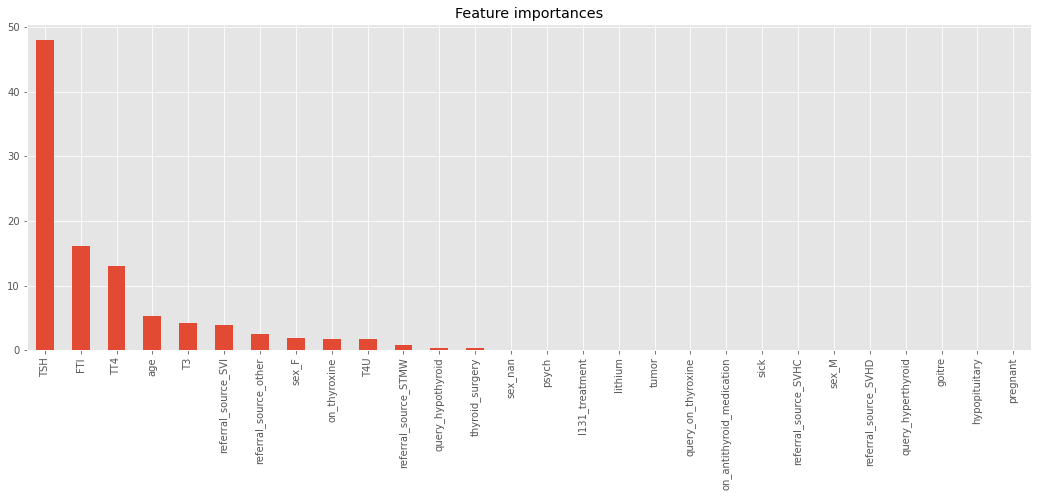

In [30]:
feature_importance = pd.Series(index = ind, data = ppl_cat.named_steps['catboostclassifier'].get_feature_importance())

feature_importance.sort_values(ascending=False).plot(kind = 'bar', figsize = (18,6))
plt.title('Feature importances')

As we can see the most important features are `TSH`, `FTI` and `TT4`

## NN

In [31]:

le =  LabelEncoder()
y_train_tr = le.fit_transform(y_train)
y_test_tr = le.transform(y_test)
y_train_tr = to_categorical(y_train_tr)
y_test_tr = to_categorical(y_test_tr)

In [72]:
early_stopping = EarlyStopping(monitor='val_auc', patience=5)

input_tensor = Input(shape=(28,))
hidden_tensor0 = Dense(256, kernel_initializer='normal', activation='relu')(input_tensor)
hidden_tensor1 = Dense(1024, kernel_initializer='normal', activation='relu')(hidden_tensor0)
hidden_tensor4 = Dense(512, kernel_initializer='normal', activation='relu')(hidden_tensor1)
output_tensor = Dense(3, activation='softmax')(hidden_tensor4)
model = Model(input_tensor, output_tensor)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['AUC'])

In [61]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28)]              0         
                                                                 
 dense_18 (Dense)            (None, 256)               7424      
                                                                 
 dense_19 (Dense)            (None, 1024)              263168    
                                                                 
 dense_20 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_21 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_22 (Dense)            (None, 512)               524800    
                                                                 
 dense_23 (Dense)            (None, 3)                 1539

In [45]:
print(df.Class.value_counts(normalize=True))
weights = np.round(1/df.Class.value_counts(normalize=True))
class_weight = {0: weights[1], 1: weights[0], 2: weights[2]}
class_weight

negative                   0.921563
compensated_hypothyroid    0.052291
sec_or_pr_hypothyroid      0.026146
Name: Class, dtype: float64


{0: 19.0, 1: 1.0, 2: 38.0}

In [74]:
%%time 
history = model.fit(X_train_tr, 
                    y_train_tr, 
                    epochs=100, 
                    batch_size=128, 
                    validation_split=.20, 
                    verbose=True, 
                    class_weight=class_weight,)
                   # callbacks = [early_stopping])

Epoch 1/100
18/18 [==============================] - 1s 34ms/step - loss: 1.2439 - auc: 0.9086 - val_loss: 0.4490 - val_auc: 0.9370
Epoch 2/100
18/18 [==============================] - 1s 31ms/step - loss: 1.1660 - auc: 0.9280 - val_loss: 0.5885 - val_auc: 0.8967
Epoch 3/100
18/18 [==============================] - 0s 27ms/step - loss: 1.1792 - auc: 0.9113 - val_loss: 0.3202 - val_auc: 0.9696
Epoch 4/100
18/18 [==============================] - 1s 31ms/step - loss: 1.2703 - auc: 0.9218 - val_loss: 0.5003 - val_auc: 0.9185
Epoch 5/100
18/18 [==============================] - 0s 28ms/step - loss: 1.1127 - auc: 0.9285 - val_loss: 0.4529 - val_auc: 0.9333
Epoch 6/100
18/18 [==============================] - 1s 29ms/step - loss: 1.1248 - auc: 0.9206 - val_loss: 0.4116 - val_auc: 0.9468
Epoch 7/100
18/18 [==============================] - 0s 28ms/step - loss: 1.0124 - auc: 0.9444 - val_loss: 0.7274 - val_auc: 0.8690
Epoch 8/100
18/18 [==============================] - 1s 29ms/step - loss: 1.

In [75]:
y_pred = model.predict(X_test_tr)
print(f'Test AUC: {roc_auc_score(y_test_tr, y_pred, average="micro"):.3f}')

29/29 [==============================] - 0s 6ms/step
Test AUC: 0.992


In [76]:
y_pred_labels = np.argmax(y_pred, axis=-1)
y_test_tr_labels = np.argmax(y_test_tr, axis=-1)
print(classification_report(y_test_tr_labels, y_pred_labels))

              precision    recall  f1-score   support

           0       0.67      0.63      0.65        49
           1       0.98      0.98      0.98       855
           2       0.84      0.88      0.86        24

    accuracy                           0.96       928
   macro avg       0.83      0.83      0.83       928
weighted avg       0.96      0.96      0.96       928



### Training statistic

Text(0.5, 0, 'Epoch Number')

Text(0, 0.5, 'Loss')

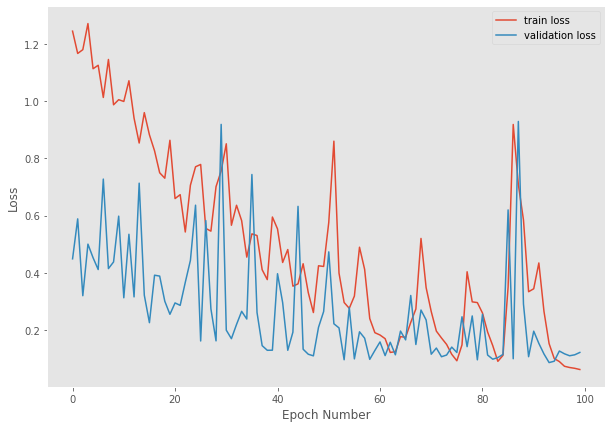

In [77]:
plt.xlabel('Epoch Number')
plt.ylabel("Loss")
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label ='validation loss')
plt.legend()
plt.grid()
plt.show()

Looks like underfitting, but adding more hidden layers doesn't fix the curves. 

# Conclusion

Using NN for imbalanced classification is trak and doesn't work good - results are pretty unstable. 